In [ ]:
# Cell 0
# Install libraries
# - transformers/datasets accelerate => for BERT + Trainer API (Hugging Face)
# - scikit-learn => for Logistic Regression baseline
# - matplotlib/seaborn => for plots
!pip -q install transformers datasets accelerate torch --upgrade
!pip -q install scikit-learn matplotlib seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
# Cell 1
# Imports and global config
import os, math, random, time
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# To make plots look nice
sns.set(style="whitegrid")

# Reproducibility
RANDOM_SEED = 6905
def set_seed(seed=RANDOM_SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [ ]:
# Cell 2
# Loading the dataset

df = pd.read_csv("EduPilot_dataset_2000.csv")

# Sanity checks
print("Columns:", list(df.columns))
print("Rows:", len(df))
print(df.head(5))

# Required columns check (will raise if missing)
required = {"text", "interview_round"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

# check for presence of label_words in "text"
def contains_label(text):
    for w in label_words:
        if w in str(text):
            return True
    return False

mask = df["text"].apply(contains_label)
df.loc[mask, ["id", "text", "interview_round"]].head(10)

Columns: ['id', 'user_query', 'job_role', 'company', 'location', 'interview_round', 'mock_question', 'text']
Rows: 2000
   id                                         user_query          job_role  \
0   1  What should I study for a Data Scientist posit...    Data Scientist   
1   2  I have an interview for SRE at Salesforce in L...               SRE   
2   3  I have an interview for Product Manager at Pin...   Product Manager   
3   4  Help me practice for Backend Engineer intervie...  Backend Engineer   
4   5  Give me common interview problems for Backend ...  Backend Engineer   

      company   location interview_round  \
0        Uber    Toronto              OA   
1  Salesforce     London              OA   
2   Pinterest    Seattle              OA   
3     Dropbox  Hyderabad              OA   
4       Apple     Munich              OA   

                                       mock_question  \
0    Count islands in a binary matrix using DFS/BFS.   
1  Given a string, return length o

,id,text,interview_round


In [ ]:
# Using 'mock_question' resulted in 1.0 accuracy
# Building a leak-safe text field that excludes both label words and `mock_question`
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

def strip_labels(text, labels):
    t = str(text)
    for w in labels:
        t = t.replace(w, "")
    return " ".join(t.split())

def make_text_safe(row):
    # DO NOT include mock_question here – it's round-specific
    parts = [
        strip_labels(row["user_query"], label_words),
        str(row["job_role"]),
        str(row["company"]),
        str(row["location"]),
    ]
    return " ||| ".join([p for p in parts if p])

df["text_safe"] = df.apply(make_text_safe, axis=1)

# Sanity: ensure no label words remain
assert not df["text_safe"].str.contains("|".join(label_words), case=False, na=False).any()

# 2) Re-split AFTER creating text_safe (important)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_df, test_df = train_test_split(
    df, test_size=0.30, stratify=df["interview_round"], random_state=6905
)

le = LabelEncoder()
y_train = le.fit_transform(train_df["interview_round"])
y_test  = le.transform(test_df["interview_round"])

# 3) Re-train Logistic Regression on text_safe
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=40000)
X_train = tfidf.fit_transform(train_df["text_safe"])
X_test  = tfidf.transform(test_df["text_safe"])

logreg = LogisticRegression(C = 0.5, max_iter=4000, solver="saga", multi_class="multinomial", random_state=6905)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)
print("LogReg — Test accuracy:", accuracy_score(y_test, y_pred))
print("LogReg — Test log-loss :", log_loss(y_test, y_proba))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg — Test accuracy: 0.20333333333333334
LogReg — Test log-loss : 1.631385871452722


In [ ]:
# Cell 5
# Get per-example negative log-likelihood (cross-entropy) for train and test
# We'll compute: loss(x) = -log( P_model(true_label | x) )
def sample_losses_logreg(model, X, true_y, eps=1e-12):
    probs = model.predict_proba(X)
    losses = []
    for i in range(len(true_y)):
        p = max(probs[i, true_y[i]], eps)
        losses.append(-math.log(p))
    return np.array(losses)

train_losses_lr = sample_losses_logreg(logreg, X_train, y_train)
test_losses_lr  = sample_losses_logreg(logreg,  X_test,  y_test)

print("LogReg — Mean loss (train):", train_losses_lr.mean())
print("LogReg — Mean loss (test): ", test_losses_lr.mean())


LogReg — Mean loss (train): 1.4117819552321618
LogReg — Mean loss (test):  1.631385871452722


In [ ]:
# Encoding 'interview_round' into integers (e.g., 0..4)
le = LabelEncoder()
y_train = le.fit_transform(train_df["interview_round"])
y_test  = le.transform(test_df["interview_round"])

num_labels = len(le.classes_)

In [ ]:
# Cell 6
# Prepare tokenizer and PyTorch datasets for BERT
MODEL_NAME = "bert-base-uncased"  # we can switch to distilbert-base-uncased too
MAX_LEN = 192

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextClsDataset(Dataset):
    """Tiny dataset wrapper to return tokenized inputs and label id."""
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding=False,
            return_tensors="pt",
        )
        # Trainer expects plain tensors (no batch dim)
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_ds_bert = TextClsDataset(train_df["text_safe"].tolist(), y_train.tolist(), tokenizer, MAX_LEN)
test_ds_bert  = TextClsDataset(test_df["text_safe"].tolist(),  y_test.tolist(),  tokenizer, MAX_LEN)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Cell 7
# Defining the model
model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

args = TrainingArguments(
    output_dir="/content/ckpt",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    seed=RANDOM_SEED,
    report_to=[],   # don't send logs to wandb
    do_eval=True    # ensures Trainer does eval when we call trainer.evaluate()
)

def compute_metrics(eval_pred):
    """Returns accuracy and log-loss for evaluation."""
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    # Convert logits to probabilities for log-loss
    probs = torch.tensor(logits).softmax(dim=-1).numpy()
    ll = log_loss(labels, probs)
    return {"accuracy": acc, "log_loss": ll}

trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=train_ds_bert,
    eval_dataset=test_ds_bert,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
eval_res = trainer.evaluate()
print("BERT — Eval:", eval_res)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3987006845.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
# Collecting per-example losses for train/test for BERT
# Manually iterating to compute loss(x) = -log P(true_label | x)

@torch.no_grad()
def batched_losses_bert(model, dataset, collator, batch_size=64, device=device):
    model.eval()
    losses = []
    for i in range(0, len(dataset), batch_size):
        batch_items = [dataset[j] for j in range(i, min(i+batch_size, len(dataset)))]
        batch = collator(batch_items)
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits  # [B, num_labels]
        log_probs = torch.log_softmax(logits, dim=-1)
        chosen = log_probs[torch.arange(log_probs.size(0)), batch["labels"]]
        losses.extend((-chosen).cpu().tolist())
    return np.array(losses)

train_losses_bert = batched_losses_bert(model_bert, train_ds_bert, collator)
test_losses_bert  = batched_losses_bert(model_bert,  test_ds_bert,  collator)

print("BERT — Mean loss (train):", train_losses_bert.mean())
print("BERT — Mean loss (test): ", test_losses_bert.mean())


BERT — Mean loss (train): 1.598018695797239
BERT — Mean loss (test):  1.6077051200469334


MIA AUC — LogReg: 0.7762 | BERT: 0.5362
TPR@FPR<=0.100 — LogReg: 0.4093 | BERT: 0.1464
TPR@FPR<=0.010 — LogReg: 0.0807 | BERT: 0.0157
TPR@FPR<=0.001 — LogReg: 0.0300 | BERT: 0.0079


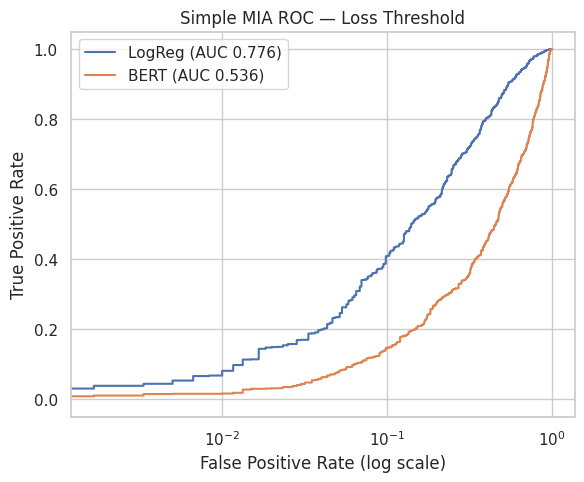

In [ ]:
# Cell 9
# Simple MIA using per-example loss (lower loss => more likely member)
# We'll compute ROC/AUC for BOTH models, and print TPR at low FPR.

def mia_scores_and_labels(train_losses, test_losses):
    # Higher score => more member-like (so we use negative loss)
    scores = np.concatenate([-train_losses, -test_losses])
    is_member = np.concatenate([np.ones_like(train_losses), np.zeros_like(test_losses)])
    return scores, is_member

scores_lr, is_member_lr = mia_scores_and_labels(train_losses_lr, test_losses_lr)
scores_bert, is_member_bert = mia_scores_and_labels(train_losses_bert, test_losses_bert)

# ROC curves
fpr_lr,   tpr_lr,   _ = roc_curve(is_member_lr, scores_lr)
auc_lr = auc(fpr_lr, tpr_lr)
fpr_bert, tpr_bert, _ = roc_curve(is_member_bert, scores_bert)
auc_bert = auc(fpr_bert, tpr_bert)

print(f"MIA AUC — LogReg: {auc_lr:.4f} | BERT: {auc_bert:.4f}")

# Function to print TPR@FPR thresholds
def tpr_at_fpr(fpr, tpr, target):
    mask = fpr <= target
    return float(tpr[mask].max()) if mask.any() else 0.0

for target in [0.1, 0.01, 0.001]:
    print(f"TPR@FPR<={target:.3f} — LogReg: {tpr_at_fpr(fpr_lr, tpr_lr, target):.4f} | BERT: {tpr_at_fpr(fpr_bert, tpr_bert, target):.4f}")

# Plot ROC curves together (log-scale on x to emphasize low FPR)
plt.figure(figsize=(6.5,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC {auc_lr:.3f})')
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC {auc_bert:.3f})')
plt.xscale('log')
plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate")
plt.title("Simple MIA ROC — Loss Threshold")
plt.legend()
plt.grid(True)
plt.show()


Training LogReg shadow models...


  0%|          | 0/512 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
  0%|          | 1/512 [00:00<01:53,  4.51it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
  0%|          | 2/512 [00:00<01:40,  5.06it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
  1%|       

LiRA (LogReg) — AUC: 0.6092
LiRA (LogReg) TPR@FPR<=0.100: 0.1893
LiRA (LogReg) TPR@FPR<=0.010: 0.0457
LiRA (LogReg) TPR@FPR<=0.001: 0.0000


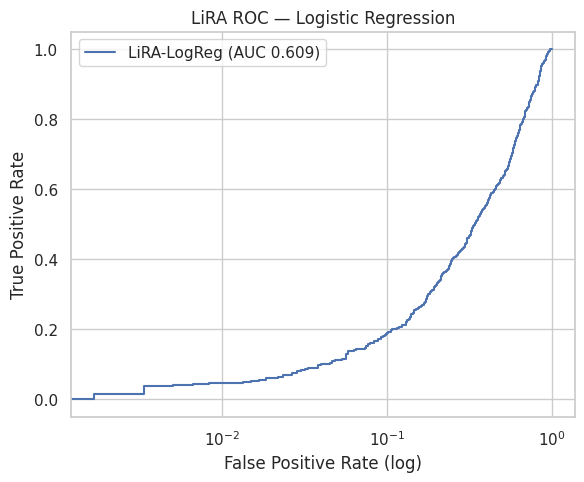

In [ ]:
# Cell 10
# Proper LiRA for Logistic Regression (shadow models + Gaussian LLR)
# These shadows are fast with LogReg + TF-IDF on 2000 rows.
# I have increased SHADOWS to 512 for stronger estimates

SHADOWS = 512          # number of shadow models
SAMPLE_FRAC = 0.6        # fraction of dataset to include in each shadow (random subset)
MAX_FEATURES_SHADOW = 20000

# Build full-corpus arrays for convenience
all_texts = df["text"].tolist()
all_labels_str = df["interview_round"].tolist()

# We'll map labels to integers once for ground truth consistency
le_global = LabelEncoder().fit(all_labels_str)
all_labels = le_global.transform(all_labels_str)
num_examples = len(all_texts)

# Storage for IN/OUT loss lists per example
in_losses = [[] for _ in range(num_examples)]
out_losses = [[] for _ in range(num_examples)]

print("Training LogReg shadow models...")
for s in tqdm(range(SHADOWS)):
    # Random subset indices to train this shadow
    subsz = max(10, int(SAMPLE_FRAC * num_examples))
    subs_idx = np.random.choice(num_examples, subsz, replace=False)
    subs_idx_set = set(subs_idx.tolist())

    # Fit a TF-IDF + LogReg on the subset (properly refitting each shadow)
    tfidf_s = TfidfVectorizer(ngram_range=(1,2), max_features=MAX_FEATURES_SHADOW)
    X_s_train = tfidf_s.fit_transform([all_texts[i] for i in subs_idx])
    y_s_train = le_global.transform([all_labels_str[i] for i in subs_idx])  # consistent label ids

    lr_s = LogisticRegression(
        max_iter=1000, solver="saga", multi_class="multinomial", random_state=s
    )
    try:
        lr_s.fit(X_s_train, y_s_train)
    except Exception:
        # fallback if saga fails on tiny shards
        lr_s = LogisticRegression(max_iter=1000, solver="liblinear", multi_class="ovr", random_state=s)
        lr_s.fit(X_s_train, y_s_train)

    # Evaluating loss for all examples under this shadow
    X_all_s = tfidf_s.transform(all_texts)
    proba_all = lr_s.predict_proba(X_all_s)

    # Append each example's loss to IN or OUT bag
    for idx in range(num_examples):
        y_idx = all_labels[idx]
        p = max(proba_all[idx, y_idx], 1e-12)
        loss = -math.log(p)
        if idx in subs_idx_set:
            in_losses[idx].append(loss)
        else:
            out_losses[idx].append(loss)

# Compute Gaussian LLR per example
def log_gauss(x, mu, var):
    return -0.5 * (math.log(2*math.pi*var) + ((x - mu)**2)/var)

lira_scores_lr = np.zeros(num_examples, dtype=float)

# We'll use the baseline LogReg model's per-example loss as "x" for LiRA scoring.
# First, compute baseline LR loss for ALL examples (not just train/test).
X_all_base = tfidf.transform(df["text"])
base_losses_lr_all = sample_losses_logreg(logreg, X_all_base, le.transform(df["interview_round"]))

for idx in range(num_examples):
    in_arr  = np.array(in_losses[idx]) if len(in_losses[idx]) else np.array([0.0, 0.0])  # guard
    out_arr = np.array(out_losses[idx]) if len(out_losses[idx]) else np.array([0.0, 1.0]) # guard
    mu_in, var_in   = float(np.mean(in_arr)),  float(np.var(in_arr) + 1e-8)
    mu_out, var_out = float(np.mean(out_arr)), float(np.var(out_arr) + 1e-8)
    x = float(base_losses_lr_all[idx])
    lira_scores_lr[idx] = log_gauss(x, mu_in, var_in) - log_gauss(x, mu_out, var_out)

# Ground-truth membership for ROC: rows in train_df are "members", rows in test_df are "non-members"
import numpy as np
is_member_lr_all = np.array(df.index.isin(train_df.index)).astype(int)

# Evaluate LiRA ROC/AUC
fpr_lira_lr, tpr_lira_lr, _ = roc_curve(is_member_lr_all, lira_scores_lr)
auc_lira_lr = auc(fpr_lira_lr, tpr_lira_lr)
print(f"LiRA (LogReg) — AUC: {auc_lira_lr:.4f}")

for target in [0.1, 0.01, 0.001]:
    mask = fpr_lira_lr <= target
    tpr_val = float(tpr_lira_lr[mask].max()) if mask.any() else 0.0
    print(f"LiRA (LogReg) TPR@FPR<={target:.3f}: {tpr_val:.4f}")

# Plot LiRA ROC for LogReg
plt.figure(figsize=(6.5,5))
plt.plot(fpr_lira_lr, tpr_lira_lr, label=f'LiRA-LogReg (AUC {auc_lira_lr:.3f})')
plt.xscale('log'); plt.xlabel("False Positive Rate (log)"); plt.ylabel("True Positive Rate")
plt.title("LiRA ROC — Logistic Regression")
plt.legend(); plt.grid(True); plt.show()


In [ ]:
import numpy as np

# Convert your per-example lists to arrays with safe defaults
def to_arr(lst):
    return np.array(lst if len(lst) else [np.nan])

IN = [to_arr(x) for x in in_losses]   # from your LiRA shadow loop
OUT = [to_arr(x) for x in out_losses]
LLR = np.array(lira_scores_lr)        # your LiRA scores per example

# Select example indices:
idx_high = int(np.nanargmax(LLR))     # looks very "member-like" per LiRA
idx_low  = int(np.nanargmin(LLR))     # looks very "non-member-like"
idx_mid  = int(np.argsort(np.nan_to_num(LLR))[len(LLR)//2])  # ambiguous
idxs = [idx_high, idx_mid, idx_low]
print("Chosen example indices (high, mid, low LLR):", idxs)


Chosen example indices (high, mid, low LLR): [1680, 1534, 1939]


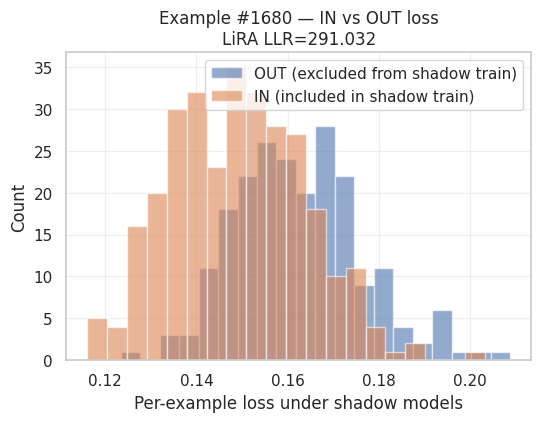

Stats for example #1680
 IN : {'n': 299, 'mean': 0.14919535850130097, 'std': 0.014735037244002469}
 OUT: {'n': 213, 'mean': 0.16246400725433116, 'std': 0.014034784216570376}
--------------------------------------------------


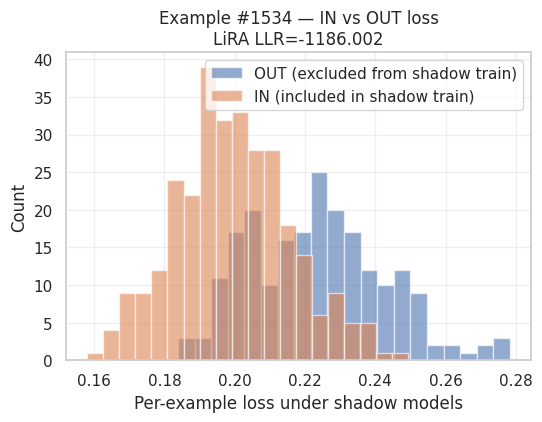

Stats for example #1534
 IN : {'n': 300, 'mean': 0.19965036152840615, 'std': 0.016330543848961977}
 OUT: {'n': 212, 'mean': 0.22365983900168013, 'std': 0.01917933439666499}
--------------------------------------------------


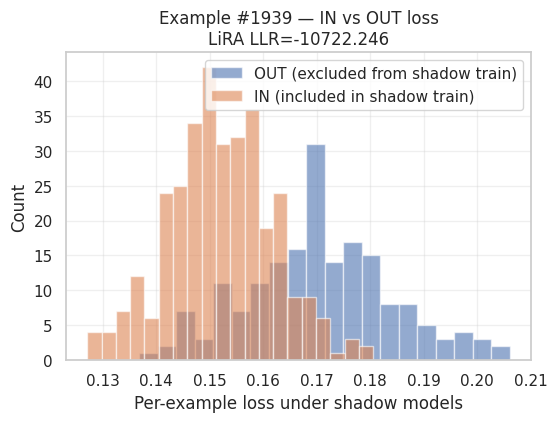

Stats for example #1939
 IN : {'n': 330, 'mean': 0.1521487209345292, 'std': 0.009686318065589263}
 OUT: {'n': 182, 'mean': 0.17041008564686164, 'std': 0.013619366050990352}
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt

def summarize(arr):
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return {"n": 0, "mean": np.nan, "std": np.nan}
    return {"n": arr.size, "mean": float(arr.mean()), "std": float(arr.std() + 1e-12)}

def plot_in_out_for(idx, bins=20):
    in_arr  = IN[idx][~np.isnan(IN[idx])]
    out_arr = OUT[idx][~np.isnan(OUT[idx])]

    plt.figure(figsize=(6,4))
    plt.hist(out_arr, bins=bins, alpha=0.6, label="OUT (excluded from shadow train)")
    plt.hist(in_arr,  bins=bins, alpha=0.6, label="IN (included in shadow train)")
    plt.xlabel("Per-example loss under shadow models")
    plt.ylabel("Count")
    plt.title(f"Example #{idx} — IN vs OUT loss\nLiRA LLR={LLR[idx]:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Stats for example #{idx}")
    print(" IN :", summarize(in_arr))
    print(" OUT:", summarize(out_arr))
    print("-"*50)

# Plot a few
for i in idxs:
    plot_in_out_for(i)


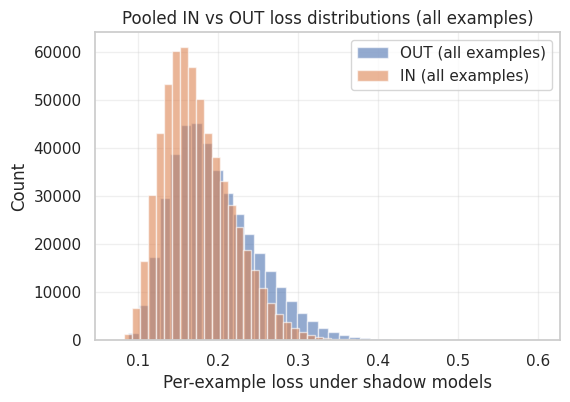

Pooled stats:
 IN : {'n': 614400, 'mean': 0.17505778213107226, 'std': 0.04376206940259733}
 OUT: {'n': 409600, 'mean': 0.19484968035044548, 'std': 0.05287740241935801}


In [ ]:
all_in  = np.concatenate([x[~np.isnan(x)] for x in IN if x.size > 0])
all_out = np.concatenate([x[~np.isnan(x)] for x in OUT if x.size > 0])

plt.figure(figsize=(6,4))
plt.hist(all_out, bins=40, alpha=0.6, label="OUT (all examples)")
plt.hist(all_in,  bins=40, alpha=0.6, label="IN (all examples)")
plt.xlabel("Per-example loss under shadow models")
plt.ylabel("Count")
plt.title("Pooled IN vs OUT loss distributions (all examples)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Pooled stats:")
print(" IN :", summarize(all_in))
print(" OUT:", summarize(all_out))


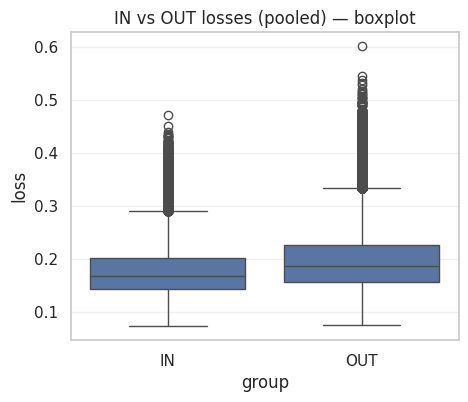

In [ ]:
import pandas as pd
import seaborn as sns

df_plot = pd.DataFrame({
    "loss": np.concatenate([all_in, all_out]),
    "group": np.array(["IN"]*len(all_in) + ["OUT"]*len(all_out))
})
plt.figure(figsize=(5,4))
sns.boxplot(data=df_plot, x="group", y="loss")
plt.title("IN vs OUT losses (pooled) — boxplot")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


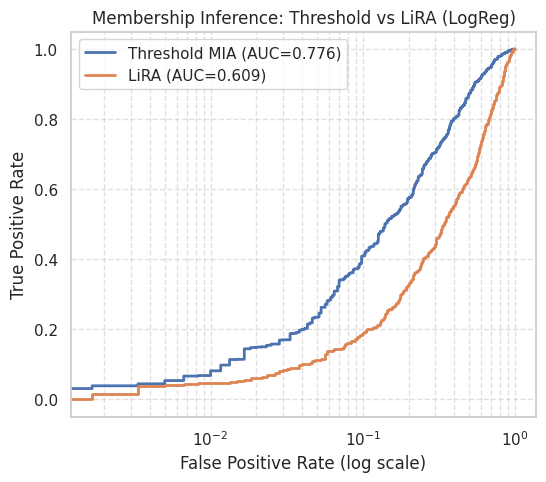

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

# --- Threshold MIA ROC (you already have fpr_lr, tpr_lr for LogReg) ---
fpr_thresh,   tpr_thresh,   _ = roc_curve(is_member_lr, scores_lr)
auc_thresh = auc(fpr_lr, tpr_lr)

# --- LiRA ROC (from your shadow eval) ---
fpr_lira, tpr_lira, _ = metrics.roc_curve(is_member_lr_all, lira_scores_lr)
auc_lira = metrics.roc_auc_score(is_member_lr_all, lira_scores_lr)

# --- Plot both curves ---
plt.figure(figsize=(6,5))
plt.plot(fpr_thresh, tpr_thresh, label=f"Threshold MIA (AUC={auc_thresh:.3f})", lw=2)
plt.plot(fpr_lira, tpr_lira, label=f"LiRA (AUC={auc_lira:.3f})", lw=2)

plt.xscale("log")  # log scale to highlight low-FPR region
plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate")
plt.title("Membership Inference: Threshold vs LiRA (LogReg)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()


In [ ]:
# # Cell 11 — OPTIONAL: Approximate LiRA for BERT (compute-heavy). Disabled by default.
# ENABLE_LIRA_BERT = False
# SHADOWS_BERT = 4                 # try 4 or 6
# SAMPLE_FRAC_BERT = 0.7
# EPOCHS_SHADOW_BERT = 1           # single epoch only to speed up things

# lira_scores_bert = None
# auc_lira_bert = None

# if ENABLE_LIRA_BERT:
#     in_losses_b = [[] for _ in range(num_examples)]
#     out_losses_b = [[] for _ in range(num_examples)]
#     print("Training BERT shadow models (this is slow)...")
#     for s in range(SHADOWS_BERT):
#         subsz = max(10, int(SAMPLE_FRAC_BERT * num_examples))
#         subs_idx = np.random.choice(num_examples, subsz, replace=False)
#         subs_idx_set = set(subs_idx.tolist())

#         # Build shadow train dataset
#         texts_sub = [all_texts[i] for i in subs_idx]
#         y_sub    = [all_labels[i] for i in subs_idx]

#         ds_shadow = TextClsDataset(texts_sub, y_sub, tokenizer, MAX_LEN)
#         # We'll evaluate losses on ALL examples
#         ds_all_for_eval = TextClsDataset(all_texts, all_labels, tokenizer, MAX_LEN)

#         # Tiny model copy
#         model_s = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

#         args_s = TrainingArguments(
#             output_dir=f"/content/ckpt_shadow_{s}",
#             per_device_train_batch_size=16,
#             per_device_eval_batch_size=32,
#             learning_rate=2e-5,
#             num_train_epochs=EPOCHS_SHADOW_BERT,
#             weight_decay=0.01,
#             logging_steps=200,
#             seed=RANDOM_SEED + s,
#             report_to=[],
#             do_eval=False
#         )
#         trainer_s = Trainer(
#             model=model_s,
#             args=args_s,
#             train_dataset=ds_shadow,
#             data_collator=collator,
#             tokenizer=tokenizer,
#         )
#         trainer_s.train()

#         # Collect losses for ALL examples under this shadow
#         losses_all = batched_losses_bert(model_s, ds_all_for_eval, collator, batch_size=64, device=device)
#         for idx in range(num_examples):
#             if idx in subs_idx_set:
#                 in_losses_b[idx].append(losses_all[idx])
#             else:
#                 out_losses_b[idx].append(losses_all[idx])

#     # Baseline BERT loss for ALL examples
#     base_losses_bert_all = batched_losses_bert(model_bert, TextClsDataset(all_texts, all_labels, tokenizer, MAX_LEN), collator)

#     # Gaussian LLR per example
#     lira_scores_bert = np.zeros(num_examples, dtype=float)
#     for idx in range(num_examples):
#         in_arr  = np.array(in_losses_b[idx]) if len(in_losses_b[idx]) else np.array([0.0, 0.0])
#         out_arr = np.array(out_losses_b[idx]) if len(out_losses_b[idx]) else np.array([0.0, 1.0])
#         mu_in, var_in   = float(np.mean(in_arr)),  float(np.var(in_arr) + 1e-8)
#         mu_out, var_out = float(np.mean(out_arr)), float(np.var(out_arr) + 1e-8)
#         x = float(base_losses_bert_all[idx])
#         lira_scores_bert[idx] = log_gauss(x, mu_in, var_in) - log_gauss(x, mu_out, var_out)

#     is_member_all = df.index.isin(train_df.index).astype(int).values
#     fpr_b, tpr_b, _ = roc_curve(is_member_all, lira_scores_bert)
#     auc_lira_bert = auc(fpr_b, tpr_b)
#     print(f"LiRA (BERT, approx) — AUC: {auc_lira_bert:.4f}")
#     for target in [0.1, 0.01, 0.001]:
#         mask = fpr_b <= target
#         tpr_val = float(tpr_b[mask].max()) if mask.any() else 0.0
#         print(f"LiRA (BERT) TPR@FPR<={target:.3f}: {tpr_val:.4f}")

#     plt.figure(figsize=(6.5,5))
#     plt.plot(fpr_b, tpr_b, label=f'LiRA-BERT (AUC {auc_lira_bert:.3f})')
#     plt.xscale('log'); plt.xlabel("False Positive Rate (log)"); plt.ylabel("True Positive Rate")
#     plt.title("LiRA ROC — BERT (approx, few shadows)")
#     plt.legend(); plt.grid(True); plt.show()
# else:
#     print("Skipping LiRA for BERT (set ENABLE_LIRA_BERT=True to run).")


In [ ]:
# Cell 12 — Summary prints you can paste in your report
print("\n=== Classification Baselines ===")
# LogReg
print(f"LogReg Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"LogReg Test Log-Loss : {log_loss(y_test, y_proba):.4f}")
# BERT
# Already printed eval dict above; extract for consistency:
_, logits = None, None
# We'll re-evaluate quickly to print in same style:
probs_bert_test = []
labels_bert_test = []

@torch.no_grad()
def softmax_np(x): return (torch.tensor(x).softmax(dim=-1).numpy())

model_bert.eval()
probs_bert_test = []
labels_bert_test = []
for i in range(0, len(test_ds_bert), 64):
    batch = [test_ds_bert[j] for j in range(i, min(i+64, len(test_ds_bert)))]
    batch = collator(batch)
    batch = {k: v.to(device) for k, v in batch.items()}
    logits = model_bert(**batch).logits
    probs_bert_test.extend(torch.softmax(logits, dim=-1).cpu().numpy().tolist())
    labels_bert_test.extend(batch["labels"].cpu().numpy().tolist())

probs_bert_test = np.array(probs_bert_test)
labels_bert_test = np.array(labels_bert_test)
preds_bert = probs_bert_test.argmax(axis=1)

print(f"BERT Test Accuracy : {accuracy_score(labels_bert_test, preds_bert):.4f}")
print(f"BERT Test Log-Loss  : {log_loss(labels_bert_test, probs_bert_test):.4f}")

print("\n=== Simple MIA (Loss threshold) AUC ===")
print(f"LogReg: {auc_lr:.4f} | BERT: {auc_bert:.4f}")

print("\n=== LiRA (Gaussian LLR) AUC ===")
print(f"LogReg: {auc_lira_lr:.4f}")
if 'auc_lira_bert' in globals() and auc_lira_bert is not None:
    print(f"BERT : {auc_lira_bert:.4f} (approx)")
else:
    print("BERT : skipped (enable in Cell 11 to run)")



=== Classification Baselines ===
LogReg Test Accuracy: 0.2033
LogReg Test Log-Loss : 1.6314


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Classes: ['Behavioral/HR', 'ML Case Study', 'OA', 'System Design', 'Technical']
Training on 1400 samples; validating on 600 samples...
Epoch 01: train loss 1.6098 acc 0.191 | test loss 1.6096 acc 0.188
Epoch 02: train loss 1.5975 acc 0.415 | test loss 1.6093 acc 0.200
Epoch 04: train loss 1.5592 acc 0.585 | test loss 1.6100 acc 0.215
Epoch 06: train loss 1.4790 acc 0.621 | test loss 1.6174 acc 0.212
Epoch 08: train loss 1.3559 acc 0.669 | test loss 1.6374 acc 0.215
Epoch 10: train loss 1.2078 acc 0.714 | test loss 1.6769 acc 0.200
Epoch 12: train loss 1.0559 acc 0.771 | test loss 1.7329 acc 0.202
Epoch 14: train loss 0.9110 acc 0.811 | test loss 1.7992 acc 0.203
Epoch 16: train loss 0.7821 acc 0.846 | test loss 1.8745 acc 0.208
Epoch 18: train loss 0.6731 acc 0.876 | test loss 1.9591 acc 0.203


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(



MLP — Test accuracy: 0.2033
MLP — Test log-loss : 1.9591
Mean losses — train: 0.6291 | test: 1.9591

[Threshold MIA] ROC-AUC (MLP): 0.9322
TPR@FPR<=0.100 (MLP): 0.7679
TPR@FPR<=0.010 (MLP): 0.3121
TPR@FPR<=0.001 (MLP): 0.0643


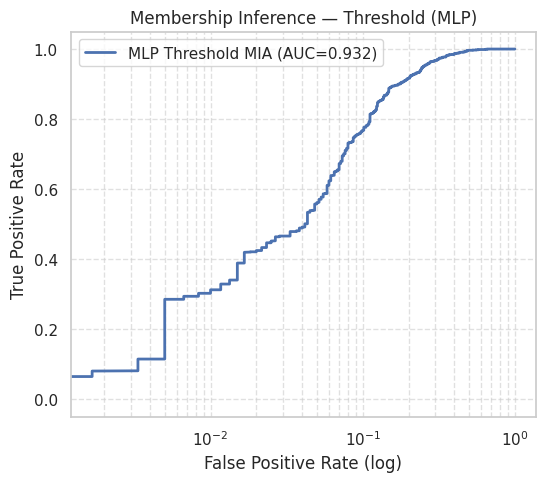

In [ ]:
# ============================================================
# TF-IDF  →  2-layer MLP (PyTorch)  →  MIA (threshold + optional LiRA)
# ============================================================
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# 0) Config
# -------------------------
RANDOM_SEED = 6905
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

TEXT_COL = "text_safe" if "text_safe" in df.columns else "text"  # prefer leak-safe text
LABEL_COL = "interview_round"
TEST_SIZE = 0.30

# Vectorizer params (high capacity → mild overfitting → stronger MIA)
NGRAMS = (1,3)
MAX_FEATS = 40_000

# MLP params (intentionally a bit over-parameterized)
HID = 512
EPOCHS = 18
BATCH = 64
LR = 3e-4
WEIGHT_DECAY = 0.0  # keep 0 to allow some overfitting

# Optional LiRA (shadow models) — set True only if you want to run it
ENABLE_LIRA = False
SHADOWS = 64           # increase to 128 or 256 if you have time/compute
SAMPLE_FRAC = 0.6      # <= 0.6 gives more diversity (helps LiRA)
SHADOW_EPOCHS = 8      # keep small so it finishes

# -------------------------
# 1) Split + labels
# -------------------------
train_df, test_df = train_test_split(
    df, test_size=TEST_SIZE, stratify=df[LABEL_COL], random_state=RANDOM_SEED
)

le = LabelEncoder()
y_train = le.fit_transform(train_df[LABEL_COL])
y_test  = le.transform(test_df[LABEL_COL])
num_labels = len(le.classes_)
print("Classes:", list(le.classes_))

# -------------------------
# 2) TF-IDF features
# -------------------------
tfidf = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATS)
X_train = tfidf.fit_transform(train_df[TEXT_COL])
X_test  = tfidf.transform(test_df[TEXT_COL])

# Helper dataset that reads from a CSR matrix without densifying the whole thing
class CSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        # convert this row to a dense float32 vector on the fly
        x = torch.tensor(self.X[idx].toarray()[0], dtype=torch.float32)
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

train_ds = CSRDataset(X_train, y_train)
test_ds  = CSRDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# -------------------------
# 3) Define 2-layer MLP
# -------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hid, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits

mlp = MLP(in_dim=X_train.shape[1], hid=HID, out_dim=num_labels).to(device)
opt = torch.optim.Adam(mlp.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

# -------------------------
# 4) Train
# -------------------------
def run_epoch(loader, train=True):
    model = mlp
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total_loss += float(loss.item()) * xb.size(0)
            total_correct += int((logits.argmax(-1) == yb).sum().item())
            total_n += xb.size(0)
    return total_loss/total_n, total_correct/total_n

print(f"Training on {len(train_ds)} samples; validating on {len(test_ds)} samples...")
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    if ep % 2 == 0 or ep == 1:
        print(f"Epoch {ep:02d}: train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")

# -------------------------
# 5) Final evaluation + per-example losses
# -------------------------
@torch.no_grad()
def collect_losses(loader):
    model = mlp
    model.eval()
    losses, probs, labels = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        lp = F.log_softmax(logits, dim=-1)
        chosen = lp[torch.arange(lp.size(0)), yb]  # log prob of the true class
        losses.extend((-chosen).cpu().numpy().tolist())
        probs.extend(torch.softmax(logits, dim=-1).cpu().numpy().tolist())
        labels.extend(yb.cpu().numpy().tolist())
    return np.array(losses), np.array(probs), np.array(labels)

train_losses_mlp, train_probs_mlp, train_y_true = collect_losses(train_loader)
test_losses_mlp,  test_probs_mlp,  test_y_true  = collect_losses(test_loader)

# Accuracy and log-loss on test
test_pred_mlp = test_probs_mlp.argmax(axis=1)
acc_mlp = accuracy_score(test_y_true, test_pred_mlp)
ll_mlp  = log_loss(test_y_true, test_probs_mlp)
print(f"\nMLP — Test accuracy: {acc_mlp:.4f}")
print(f"MLP — Test log-loss : {ll_mlp:.4f}")
print(f"Mean losses — train: {train_losses_mlp.mean():.4f} | test: {test_losses_mlp.mean():.4f}")

# -------------------------
# 6) Simple Threshold MIA (Shokri-style): ROC/AUC + TPR@low-FPR
# -------------------------
scores_mia = np.concatenate([-train_losses_mlp, -test_losses_mlp])  # higher => more member-like
is_member   = np.concatenate([np.ones_like(train_losses_mlp), np.zeros_like(test_losses_mlp)])

fpr_mia, tpr_mia, _ = roc_curve(is_member, scores_mia)
auc_mia = auc(fpr_mia, tpr_mia)
print(f"\n[Threshold MIA] ROC-AUC (MLP): {auc_mia:.4f}")

def tpr_at_fpr(fpr, tpr, target):
    idx = np.where(fpr <= target)[0]
    return float(tpr[idx].max()) if idx.size > 0 else 0.0

for target in [0.1, 0.01, 0.001]:
    print(f"TPR@FPR<={target:.3f} (MLP): {tpr_at_fpr(fpr_mia, tpr_mia, target):.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr_mia, tpr_mia, label=f"MLP Threshold MIA (AUC={auc_mia:.3f})", lw=2)
plt.xscale("log"); plt.xlabel("False Positive Rate (log)"); plt.ylabel("True Positive Rate")
plt.title("Membership Inference — Threshold (MLP)")
plt.grid(True, which="both", ls="--", alpha=0.6); plt.legend(); plt.show()





[LiRA] training shadow MLPs — this can take time...


100%|██████████| 512/512 [03:07<00:00,  2.72it/s]



[LiRA MLP] ROC-AUC: 0.5029
TPR@FPR<=0.100 (LiRA MLP): 0.1714
TPR@FPR<=0.010 (LiRA MLP): 0.0164
TPR@FPR<=0.001 (LiRA MLP): 0.0036


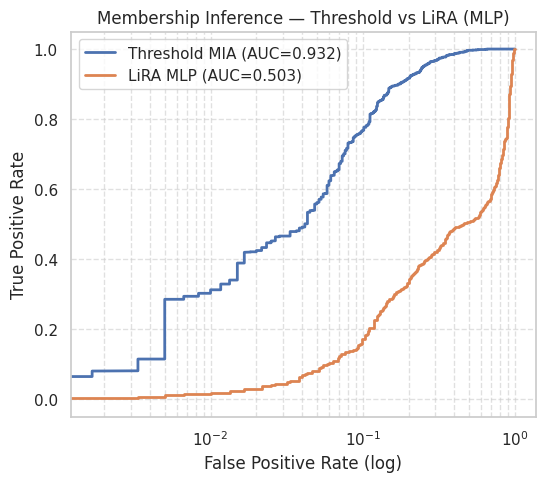

In [ ]:
ENABLE_LIRA = True
SHADOWS = 512
SAMPLE_FRAC = 0.6
SHADOW_EPOCHS = 6-8


# ============================================================
# 7) LiRA for the MLP (shadow models)
# ============================================================
if ENABLE_LIRA:
    print("\n[LiRA] training shadow MLPs — this can take time...")
    # Prepare full-corpus arrays for shadows
    all_texts = df[TEXT_COL].tolist()
    all_labels_str = df[LABEL_COL].tolist()
    le_global = LabelEncoder().fit(all_labels_str)
    all_y = le_global.transform(all_labels_str)
    num_examples = len(all_texts)

    # Vectorizer for shadows (fit on each shadow subset)
    def train_shadow(indices, seed):
        # Train a shadow MLP on subset 'indices'
        tf = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATS)
        Xs = tf.fit_transform([all_texts[i] for i in indices])
        ys = le_global.transform([all_labels_str[i] for i in indices])

        ds = CSRDataset(Xs, ys)
        loader = DataLoader(ds, batch_size=BATCH, shuffle=True)

        torch.manual_seed(seed)
        m = MLP(in_dim=Xs.shape[1], hid=HID, out_dim=num_labels).to(device)
        opt_s = torch.optim.Adam(m.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

        # train small number of epochs to keep runtime reasonable
        m.train()
        for _ in range(SHADOW_EPOCHS):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = m(xb)
                loss = criterion(logits, yb)
                opt_s.zero_grad(); loss.backward(); opt_s.step()

        # Evaluate loss for ALL examples under this shadow
        # (transform with this shadow's TF-IDF)
        X_all = tf.transform(all_texts)

        losses = []
        with torch.no_grad():
            m.eval()
            for start in range(0, num_examples, BATCH):
                end = min(start+BATCH, num_examples)
                xb = torch.tensor(X_all[start:end].toarray(), dtype=torch.float32, device=device)
                logits = m(xb)
                probs = torch.softmax(logits, dim=-1).cpu().numpy()
                yy = all_y[start:end]
                eps = 1e-12
                l = -np.log(np.clip(probs[np.arange(len(yy)), yy], eps, 1.0))
                losses.extend(l.tolist())
        return np.array(losses)

    # Build IN/OUT loss bags per example
    in_losses, out_losses = [ [] for _ in range(num_examples) ], [ [] for _ in range(num_examples) ]
    for s in tqdm(range(SHADOWS)):
        subsz = max(10, int(SAMPLE_FRAC * num_examples))
        subs_idx = np.random.choice(num_examples, subsz, replace=False)
        subs_set = set(subs_idx.tolist())
        losses_all = train_shadow(subs_idx, seed=RANDOM_SEED+s)
        for i in range(num_examples):
            if i in subs_set: in_losses[i].append(losses_all[i])
            else:             out_losses[i].append(losses_all[i])

    # Gaussian LLR per example using baseline MLP loss as the observation
    def log_gauss(x, mu, var):
        return -0.5 * (math.log(2*math.pi*var) + ((x - mu)**2)/var)

    # Compute baseline MLP loss for ALL examples using the trained baseline & baseline tfidf
    X_all_base = tfidf.transform(df[TEXT_COL])
    # get baseline per-example loss under baseline MLP
    base_losses_all = []
    mlp.eval()
    with torch.no_grad():
        for start in range(0, X_all_base.shape[0], BATCH):
            end = min(start+BATCH, X_all_base.shape[0])
            xb = torch.tensor(X_all_base[start:end].toarray(), dtype=torch.float32, device=device)
            logits = mlp(xb)
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            yy = le.transform(df[LABEL_COL].iloc[start:end])
            base_losses_all.extend((-np.log(np.clip(probs[np.arange(len(yy)), yy], 1e-12, 1.0))).tolist())
    base_losses_all = np.array(base_losses_all)

    lira_scores = np.zeros(num_examples, dtype=float)
    for i in range(num_examples):
        in_arr  = np.array(in_losses[i])  if len(in_losses[i])  else np.array([0.0, 0.0])
        out_arr = np.array(out_losses[i]) if len(out_losses[i]) else np.array([0.0, 1.0])
        mu_in, var_in   = float(np.mean(in_arr)),  float(np.var(in_arr) + 1e-8)
        mu_out, var_out = float(np.mean(out_arr)), float(np.var(out_arr) + 1e-8)
        x = float(base_losses_all[i])
        lira_scores[i] = log_gauss(x, mu_in, var_in) - log_gauss(x, mu_out, var_out)

    # Ground-truth membership: rows in train_df are members
    is_member_all = df.index.isin(train_df.index).astype(int)

    fpr_lira, tpr_lira, _ = roc_curve(is_member_all, lira_scores)
    auc_lira = auc(fpr_lira, tpr_lira)
    print(f"\n[LiRA MLP] ROC-AUC: {auc_lira:.4f}")
    for target in [0.1, 0.01, 0.001]:
        print(f"TPR@FPR<={target:.3f} (LiRA MLP): {tpr_at_fpr(fpr_lira, tpr_lira, target):.4f}")

    plt.figure(figsize=(6,5))
    plt.plot(fpr_mia, tpr_mia,  label=f"Threshold MIA (AUC={auc_mia:.3f})", lw=2)
    plt.plot(fpr_lira, tpr_lira, label=f"LiRA MLP (AUC={auc_lira:.3f})",    lw=2)
    plt.xscale("log"); plt.xlabel("False Positive Rate (log)"); plt.ylabel("True Positive Rate")
    plt.title("Membership Inference — Threshold vs LiRA (MLP)")
    plt.grid(True, which="both", ls="--", alpha=0.6); plt.legend(); plt.show()
else:
    print("\n[LiRA] Skipped. Set ENABLE_LIRA=True to run shadow models.")